Requirements:

Add `plfit` package using the following commands in a Julia session (you can also copy-paste it to a Jupyter Notebook cell and run it):
```
using PyCall
run(`$(PyCall.python) -m pip install --upgrade cython`)
run(`$(PyCall.python) -m pip install plfit`)
```
These commands need to be run only once

In [1]:
using LightGraphs
using PyCall
using PyPlot
using Statistics
using Optim
using Distributions
using FreqTables
using StatsBase
using Random
using CSV
using DataFrames

In [2]:
datadir = "../Datasets/"

"../Datasets/"

# Part 1 -- generating figures from the book

## Figure 2.1: size of the giant component

* this is for a random graph
* We try $n=100$ and $n=10000$ below

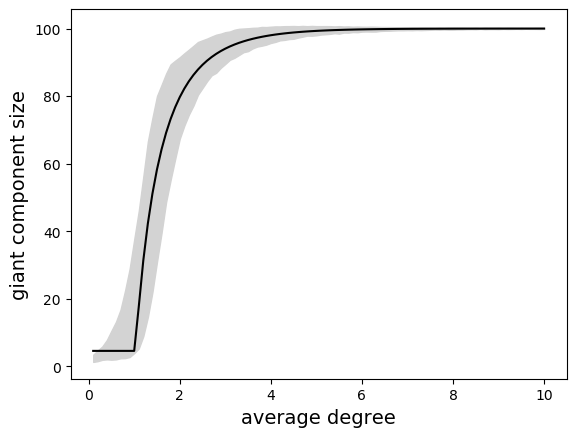

In [3]:
n = 100
# n=10000
gc_avg = Float64[]
gc_std = Float64[]
REP = 1000 ## repeats
ad = 0.1:0.1:10.0
for d in ad
    x = Int[]
    for rep in 1:REP
        p = d/(n-1)
        g = erdos_renyi(n, p)
        push!(x, maximum(length, connected_components(g)))
    end
    push!(gc_avg, mean(x))
    push!(gc_std, std(x))
end
        
## theoretical
th = fill(log(n), 10)

fn(x,d) = x + exp(-x*d) - 1

for i in 1.1:0.1:10.0
    push!(th, n * optimize( x -> fn(x, i)^2, 0, 1).minimizer[1])
end

fill_between(ad, [a-1.654*s for (a, s) in zip(gc_avg,gc_std)],
             [a+1.645*s for (a, s) in zip(gc_avg,gc_std)],color="lightgray")
plot(ad,th,color="black")
xlabel("average degree",fontsize=14)
ylabel("giant component size",fontsize=14);

## Figure 2.2: Pr(graph is connected)

* again for random graphs
* we try $n=100$ and $n=10000$ below

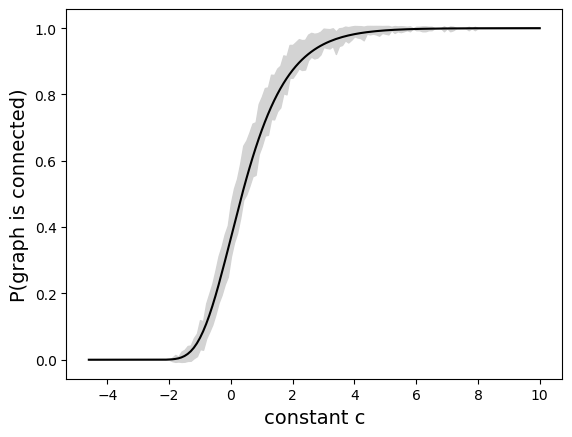

In [4]:
n = 100
# n = 10000
REP = 1000 ## repeats
lo = max(-floor(log(n)*10) / 10, -10)
C = lo:0.1:10.0
ic_avg=Float64[]
for c in C
    x = Bool[]
    for rep in 1:REP
        p = (c+log(n))/n
        g = erdos_renyi(n, p)
        push!(x, is_connected(g))
    end
    push!(ic_avg, mean(x))
end

## theoretical
th = [exp(-exp(-c)) for c in C]

## plot
fill_between(C,[x-1.654*sqrt(x*(1-x)/n) for x in ic_avg],
                 [x+1.645*sqrt(x*(1-x)/n) for x in ic_avg],color="lightgray")
plot(C,th,color="black")
xlabel("constant c",fontsize=14)
ylabel("P(graph is connected)",fontsize=14);

## Figure 2.4: Distribution of shortest path lengths

For random graphs of varying size.

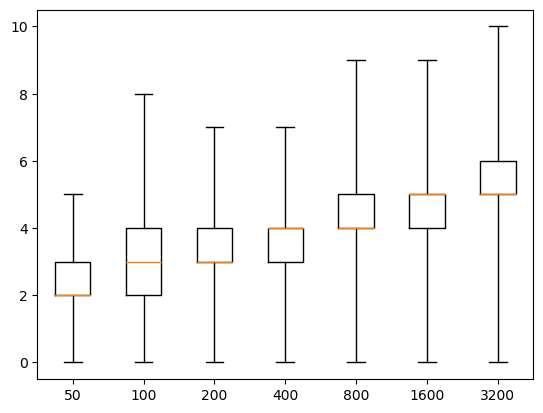

In [5]:
sp = Vector{Int}[]
N = [50,100,200,400,800,1600,3200]
for n in N
    p = 5/(n-1)
    g = erdos_renyi(n, p)
    z = Int[]
    for i in 1:n
        append!(z, gdistances(g, i))
    end
    push!(sp, z)
end
## plot    
plt.boxplot(sp, labels=N, sym="",whis=5);

## Figure 2.5 Poisson vs degree distributions

* for random graphs
* we try $n=100$ and $n=10000$ below

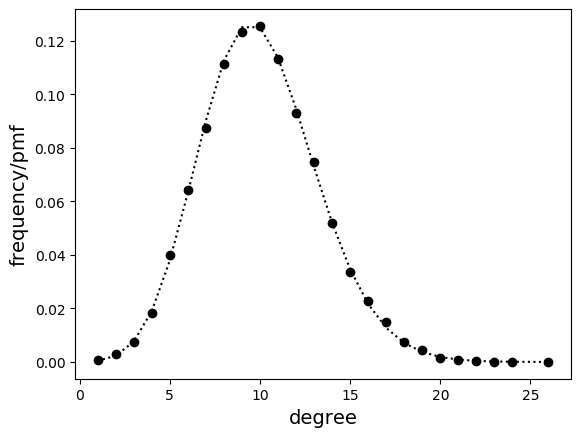

In [6]:
# n = 100
n = 10000
p = 10/(n-1)
g = erdos_renyi(n, p)
z = proptable(degree(g))
x = names(z)[1]
pmf = pdf(Poisson(10), x)
plot(x,z,"o",color="black")
plot(x,pmf,":",color="black")
xlabel("degree",fontsize=14)
ylabel("frequency/pmf",fontsize=14);

## Figure 2.6 --  Power law graphs

* We generate a power law graph and use the 'plfit' package to model its degree distribution.
* We use the Chung-Lu model, so there can be isolated nodes
* We discard 0-degree nodes as they yield errors
* Plots are from the plfit package https://pypi.org/project/plfit/

In [7]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
function fastCL(d, m)
    p = Weights(d)
    n = length(d)
    target = m
    g = SimpleGraph(n)
    while ne(g) < target
        a, b = sample(1:n, p), sample(1:n, p)
        a != b && add_edge!(g, a, b)
    end
    return g
end

fastCL (generic function with 1 method)

In [8]:
## power law graph
gamma = 2.5
n = 10000
delta = 1
Delta = sqrt(n)
W = Float64[]
for i in 1:n
    push!(W, delta * (n/(i-1+n/(Delta/delta)^(gamma-1)))^(1/(gamma-1)))
end

deg = round.(Int, W)
m = trunc(Int, mean(deg)*n/2)
g = fastCL(deg, m)

## number of isolated nodes
print("isolates: ",count(==(0), degree(g)))

g1 = induced_subgraph(g, findall(>(0), degree(g)))[1]

isolates: 2129

{7871, 13270} undirected simple Int64 graph

(11, 

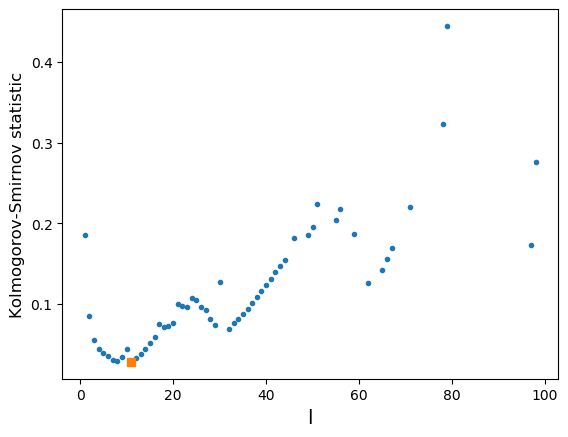

2.7845965518209477)

In [9]:
## KS statistic
d = degree(g1)
plfit = pyimport("plfit");
X = plfit.plfit(d)
print(X.plfit())
ax = X.xminvsks()
ax.set_xlabel("l",fontsize=14)
ax.set_ylabel("Kolmogorov-Smirnov statistic",fontsize=12);

In [10]:
## KS test, this can take a few minutes
KS_tst = X.test_pl(niter=100)

(0.99, [0.05451997300085365, 0.03580850742870845, 0.037489535787214145, 0.03814732718345171, 0.03552084896041624, 0.042616569641389546, 0.036198627619167034, 0.030449395144698688, 0.03270589319428639, 0.03350407936210892  …  0.045722956285909055, 0.034120044588776266, 0.040601351087974136, 0.028043283018884924, 0.03230580019352991, 0.029915529368554905, 0.03431068526376241, 0.03441228677230068, 0.03718418680451788, 0.040060864602520535])

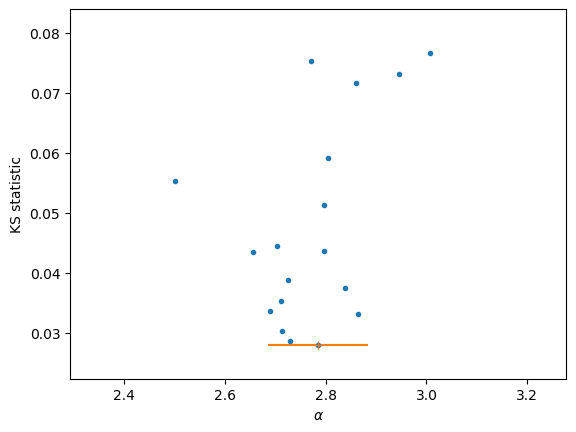

PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7f004e8dc150>

In [11]:
X.alphavsks()

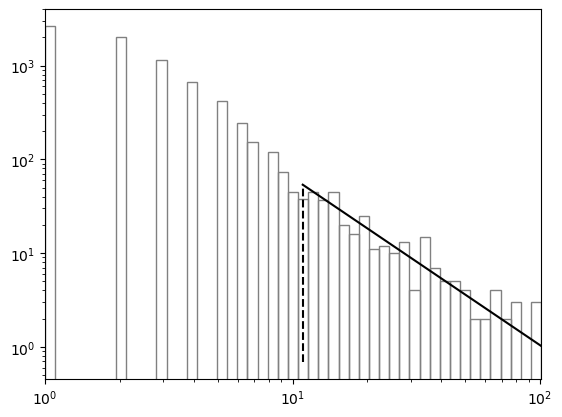

In [12]:
X.plotpdf(plcolor="k",histcolor="grey")

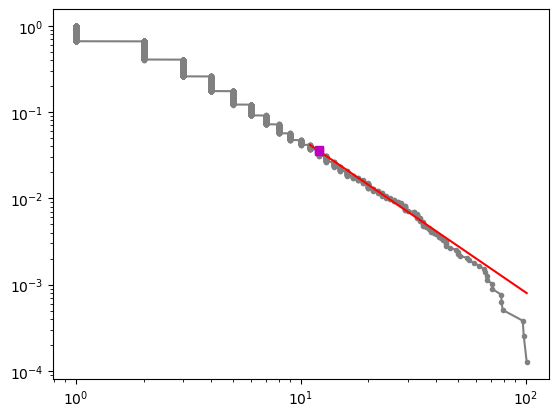

In [13]:
X.plotcdf(pointcolor="grey", pointmarker=".", zoom=false)

## Figure 2.7: simple d-regular graphs

* We empirically compute the probability that a d-regular graph is simple.
* we use n=100 and n=10000 below

In [14]:
function check_random_regular_simple(n, k)
    stubs = reduce(vcat, [fill(i, k) for i in 1:n])
    shuffle!(stubs)
    existing = Set{Tuple{Int, Int}}()
    for i in 1:2:length(stubs)
        a, b = minmax(stubs[i], stubs[i+1])
        (a == b || (a, b) in existing) && return false
        push!(existing, (a, b))
    end
    return true
end

check_random_regular_simple (generic function with 1 method)

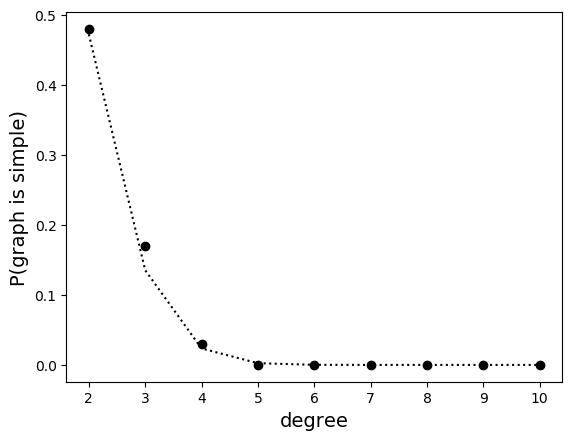

In [15]:
n = 100
# n = 10000
REP = 100
D = 2:10
simple = [mean(check_random_regular_simple(n, d) for _ in 1:REP) for d in D]
th = [exp(-(d*d-1)/4) for d in D]

plot(D,simple,"o",color="black")
plot(D,th,":",color="black")
xlabel("degree",fontsize=14)
ylabel("P(graph is simple)",fontsize=14);

# Part 2 -- Experiments section

* We consider a real graph and compare some statistics with random graphs. 
* We use the GitHub ml developers graph that we introduced in Chapter 1.

In [16]:
## read the GitHub edge list into a graph
D = CSV.read(datadir * "GitHubDevelopers/musae_git_edges.csv", DataFrame) .+ 1
max_node_id = max(maximum(D.id_1), maximum(D.id_2))
gh = SimpleGraph(max_node_id)
foreach(row -> add_edge!(gh, row...), eachrow(D))

## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = CSV.read(datadir * "GitHubDevelopers/musae_git_target.csv", DataFrame)
X.id .+= 1
@assert extrema(diff(X.id)) == (1, 1) && extrema(X.id) == (1, length(vertices(gh)))
gh_lbl = ifelse.(X.ml_target .== 0, "web", "ml");

In [17]:
gh_ml = induced_subgraph(gh, findall(==("ml"), gh_lbl))[1]

{9739, 19684} undirected simple Int64 graph

In [18]:
cc = connected_components(gh_ml)
sg = induced_subgraph(gh_ml, cc[argmax(length.(cc))])[1]

{7083, 19491} undirected simple Int64 graph

In [19]:
function baseStats(G)
    deg = degree(G)
    cc = connected_components(G)
    return Any[nv(G), ne(G),
            minimum(deg), mean(deg), median(deg), quantile(deg, 0.99), maximum(deg),
            igraph_diameter(G),
            length(cc), maximum(length, cc), count(==(0), deg),
            global_clustering_coefficient(G),
            mean(local_clustering_coefficient(G)[degree(G) .> 1])]
end

baseStats (generic function with 1 method)

In [20]:
function igraph_diameter(G)
    ccs = connected_components(G)
    ccg = [induced_subgraph(G, cc)[1] for cc in ccs]
    maximum(maximum(maximum(gdistances(g, i)) for i in vertices(g)) for g in ccg)
end

igraph_diameter (generic function with 1 method)

In [21]:
function cm_simple(ds)
    @assert iseven(sum(ds))
    stubs = reduce(vcat, fill(i, ds[i]) for i in 1:length(ds))
    shuffle!(stubs)
    local_edges = Set{Tuple{Int, Int}}()
    recycle = Tuple{Int,Int}[]
    for i in 1:2:length(stubs)
        e = minmax(stubs[i], stubs[i+1])
        if (e[1] == e[2]) || (e in local_edges)
            push!(recycle, e)
        else
            push!(local_edges, e)
        end
    end

    # resolve self-loops and duplicates
    last_recycle = length(recycle)
    recycle_counter = last_recycle
    while !isempty(recycle)
        recycle_counter -= 1
        if recycle_counter < 0
            if length(recycle) < last_recycle
                last_recycle = length(recycle)
                recycle_counter = last_recycle
            else
                break
            end
        end
        p1 = popfirst!(recycle)
        from_recycle = 2 * length(recycle) / length(stubs)
        success = false
        for _ in 1:2:length(stubs)
            p2 = if rand() < from_recycle
                used_recycle = true
                recycle_idx = rand(axes(recycle, 1))
                recycle[recycle_idx]
            else
                used_recycle = false
                rand(local_edges)
            end
            if rand() < 0.5
                newp1 = minmax(p1[1], p2[1])
                newp2 = minmax(p1[2], p2[2])
            else
                newp1 = minmax(p1[1], p2[2])
                newp2 = minmax(p1[2], p2[1])
            end
            if newp1 == newp2
                good_choice = false
            elseif (newp1[1] == newp1[2]) || (newp1 in local_edges)
                good_choice = false
            elseif (newp2[1] == newp2[2]) || (newp2 in local_edges)
                good_choice = false
            else
                good_choice = true
            end
            if good_choice
                if used_recycle
                    recycle[recycle_idx], recycle[end] = recycle[end], recycle[recycle_idx]
                    pop!(recycle)
                else
                    pop!(local_edges, p2)
                end
                success = true
                push!(local_edges, newp1)
                push!(local_edges, newp2)
                break
            end
        end
        success || push!(recycle, p1)
    end
    g = SimpleGraph(length(ds))
    for e in local_edges
        add_edge!(g, e...)
    end
    return g
end

cm_simple (generic function with 1 method)

In [22]:
er = erdos_renyi(nv(sg), ne(sg))

{7083, 19491} undirected simple Int64 graph

In [23]:
cl = expected_degree_graph(degree(sg))

{7083, 19441} undirected simple Int64 graph

In [24]:
cl2 = fastCL(degree(sg), ne(sg))

{7083, 19491} undirected simple Int64 graph

In [25]:
cm = cm_simple(degree(sg))

{7083, 19491} undirected simple Int64 graph

In [26]:
df = DataFrame("statistic" => ["nodes", "edges", "d_min", "d_mean", "d_median", "d_quant_99", "d_max",
                               "diameter", "components", "largest", "isolates", "C_glob", "C_loc"],
               "Base Graph" => baseStats(sg),
               "Erdos-Renyi" => baseStats(er),
               "Chung-Lu original" => baseStats(cl),
               "Chung-Lu fixed" => baseStats(cl2),
               "Configuration simple" => baseStats(cm))

,statistic,Base Graph,Erdos-Renyi,Chung-Lu original,Chung-Lu fixed,Configuration simple
,String,Any,Any,Any,Any,Any
1,nodes,7083,7083,7083,7083,7083
2,edges,19491,19491,19441,19491,19491
3,d_min,1,0,0,0,1
4,d_mean,5.5036,5.5036,5.48948,5.5036,5.5036
5,d_median,2.0,5.0,2.0,3.0,2.0
6,d_quant_99,47.18,11.0,52.18,49.0,47.18
7,d_max,482,17,481,399,482
8,diameter,13,10,11,10,10
9,components,1,32,1066,1078,54


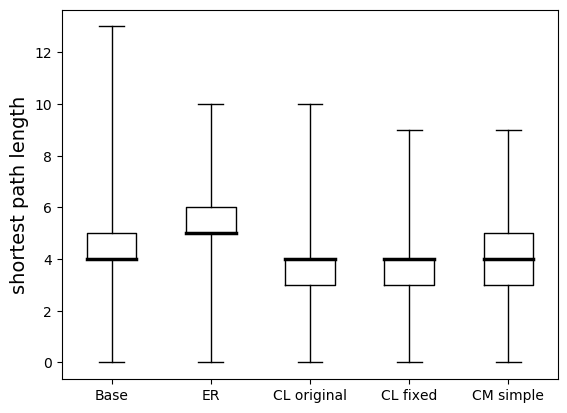

In [27]:
## compute min path length distribution for several node pairs for the 5 graphs (real and 4 random ones)
cc_er = connected_components(er)
er_g = induced_subgraph(er, cc_er[argmax(length.(cc_er))])[1]
cc_cl = connected_components(cl)
cl_g = induced_subgraph(cl, cc_cl[argmax(length.(cc_cl))])[1]
cc_cl2 = connected_components(cl2)
cl2_g = induced_subgraph(cl2, cc_cl2[argmax(length.(cc_cl2))])[1]
cc_cm = connected_components(cm)
cm_g = induced_subgraph(cm, cc_cm[argmax(length.(cc_cm))])[1]

SAMPLE_SIZE = 500

graphs = [sg, er_g, cl_g, cl2_g, cm_g]
Vs = [sample(1:nv(g), SAMPLE_SIZE, replace=false) for g in graphs]

sps = [Int[] for _ in eachindex(graphs)]
for i in 1:SAMPLE_SIZE
    for j in 1:5
        append!(sps[j], gdistances(graphs[j], Vs[j][i]))
    end
end
    
boxplot(sps,labels=["Base","ER","CL original", "CL fixed","CM simple"],
        sym=".",whis=10, medianprops = Dict("linestyle"=>"-", "linewidth"=>2.5,"color"=>"black"))
ylabel("shortest path length",fontsize=14);

## More power law tests - Grid and GitHub graphs

again with plfit package and plots

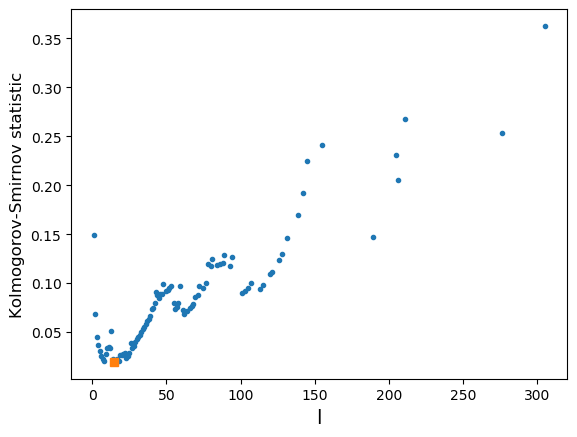

(15, 2.6233219324266894)

In [28]:
## estimates for xmin and gamma
d = degree(sg)
X = plfit.plfit(d)
print(X.plfit())
ax = X.xminvsks()
ax.set_xlabel("l",fontsize=14)
ax.set_ylabel("Kolmogorov-Smirnov statistic",fontsize=12);

In [29]:
## KS test -- very good fit here
KS_tst = X.test_pl(niter=100)

(0.99, [0.031069150251165967, 0.02780861403024526, 0.023221809264738713, 0.028233079877010125, 0.021690748579484387, 0.026156946635168543, 0.027826595328735437, 0.024503154017074424, 0.0339555614228122, 0.023725478883337092  …  0.023141345239879874, 0.019924752186240624, 0.02832360709613324, 0.02825761689627737, 0.0290445127911515, 0.02598889589491532, 0.021685528180204, 0.02260469406596366, 0.02446630288637819, 0.02710726994970558])

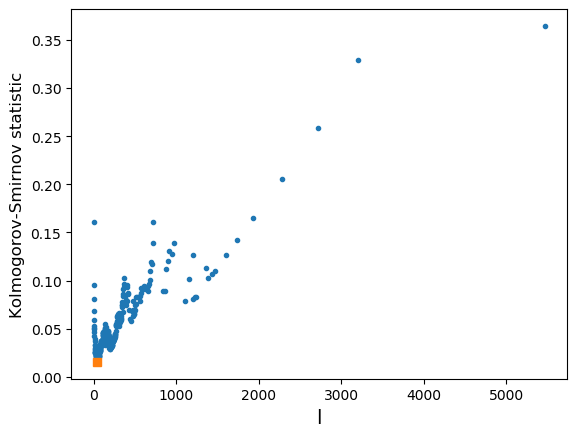

(46, 2.505994671027075)

In [30]:
## github web developers subgraph
gh_web = induced_subgraph(gh, findall(!=("ml"), gh_lbl))[1]
cc = connected_components(gh_web)
sg = induced_subgraph(gh_web, cc[argmax(length.(cc))])[1]
## estimates for xmin and gamma
d = degree(sg)
X = plfit.plfit(d)
print(X.plfit())
ax = X.xminvsks()
ax.set_xlabel("l",fontsize=14)
ax.set_ylabel("Kolmogorov-Smirnov statistic",fontsize=12);

In [31]:
## KS test -- not as good as previous graph, but still significant
KS_tst = X.test_pl(niter=100)

(0.36, [0.013427878828029427, 0.014706520829549263, 0.013938532401424286, 0.014174171236287073, 0.011215551071473373, 0.01878582617657021, 0.014827640551168697, 0.017864922333219846, 0.014785940093286654, 0.017835957093954247  …  0.009423166186093845, 0.013276073381505826, 0.014822633074482394, 0.01236892429490083, 0.012773820517209544, 0.013435128565580323, 0.012475017033381774, 0.011065071250917269, 0.013008446736127638, 0.017599905659486437])

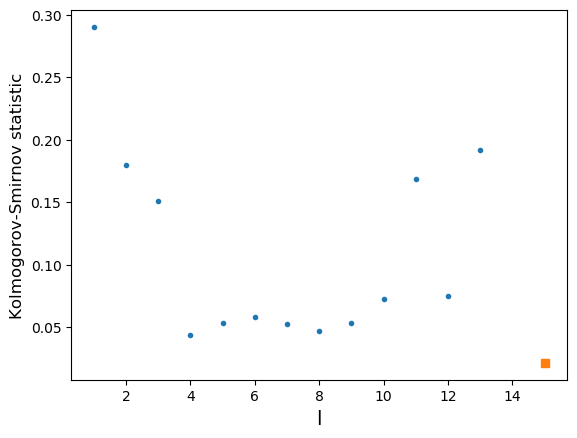

(15, 19.04585348531464)

In [32]:
edge_list = split.(readlines(datadir * "GridEurope/gridkit_europe-highvoltage.edges"))
vertex_ids = unique(reduce(vcat, edge_list))
vertex_map = Dict(vertex_ids .=> 1:length(vertex_ids))
gr = SimpleGraph(length(vertex_ids))
foreach(((from, to),) -> add_edge!(gr, vertex_map[from], vertex_map[to]), edge_list)

cc = connected_components(gr)
sg = induced_subgraph(gr, cc[argmax(length.(cc))])[1]
## estimates for xmin and gamma
d = degree(sg)
X = plfit.plfit(d)
print(X.plfit())
ax = X.xminvsks()
ax.set_xlabel("l",fontsize=14)
ax.set_ylabel("Kolmogorov-Smirnov statistic",fontsize=12);

In [33]:
## we get xmin=15 ... how many nodes does this cover? --> just a few!
count(>=(15), degree(sg))

3

In [34]:
## let's fix xmin=4 
X = plfit.plfit(d)
print(X.plfit(xmin=4))

(4, 5.860107700269038)

In [35]:
## KS test -- clearly not a good fit
KS_tst = X.test_pl(niter=100)

(0.0, [0.13209415090277926, 0.10249018650147834, 0.09924566028978632, 0.09352019008319828, 0.1023993070169511, 0.04542186710660101, 0.11984021711477166, 0.05750095580536774, 0.09369000011526263, 0.13026372299498923  …  0.08736948071553641, 0.09416062039835604, 0.07282250394721576, 0.053975234744496614, 0.1033171034120911, 0.11363147668979856, 0.06720841283158707, 0.08469204073063102, 0.09963617578960338, 0.09932894087572286])

## Extras

In [36]:
## generate random graph with (at least one) independent set 
## n: nodes, s: independent set size, d: avg degree
function indepSet(n,s,d)
    N = n-s
    di = (n*d ÷ 2) - s*d
    ## random graph with N nodes
    g = erdos_renyi(N, di)
    ## extra nodes
    add_vertices!(g, s)
    ## assign remaining degree to extra nodes
    z = rand(N+1:n, s*d)
    cm = countmap(z)
    deg = [cm[i] for i in N+1:n]
    for i in 1:length(deg)
        e = sample(1:N,deg[i],replace=false)
        for j in e
            add_edge!(g, j, i+N)
        end
    end
    return induced_subgraph(g, randperm(nv(g)))[1]
end

indepSet (generic function with 1 method)

In [37]:
function random_indset(g, maxiter)
    best = Int[]
    for _ in 1:maxiter
        this = independent_set(g, MaximalIndependentSet())
        length(this) > length(best) && (best = this)
    end
    return best
end

random_indset (generic function with 1 method)

In [38]:
g = indepSet(50,10,20)

{50, 500} undirected simple Int64 graph

In [39]:
# algorithm based on vertex degree
independent_set(g, DegreeIndependentSet())

8-element Array{Int64,1}:
 29
 38
 20
 34
 31
  2
 17
 15

In [40]:
random_indset(g, 1000)

10-element Array{Int64,1}:
 12
  7
 43
 41
 25
 48
 40
  6
 19
 42